## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 70 kB 9.8 MB/s 
     |████████████████████████████████| 112 kB 57.5 MB/s 
     |████████████████████████████████| 1.1 MB 75.7 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 288 kB 99.7 MB/s 
     |████████████████████████████████| 271 kB 89.0 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 76.2 MB/s 
     |████████████████████████████████| 749 kB 81.2 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [87]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169986, 8)


In [88]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

All caught up..!
size of dataset: (167123, 8)


In [89]:
#dir(crypto.binance_client)
crypto.binance_client.get_account()

{'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locked': '0.00000000'},
  {'asset': 'HSR', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'OAX', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'DNT', 'free': '0.000000

### Generate Candles and build features from technical analysis

In [90]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [91]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [92]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

267

,Close,Pred Close
Date,,
2022-05-08 02:01:00,34603.79,35361.709816
2022-05-08 02:16:00,34589.89,35263.404786
2022-05-08 02:31:00,34533.61,35132.917321
2022-05-08 02:46:00,34575.77,35031.404522
2022-05-08 03:01:00,34438.88,34964.394881
...,...,...
2022-06-28 14:31:00,20785.75,21058.591467
2022-06-28 14:46:00,20845.08,21045.652374
2022-06-28 15:01:00,20809.20,21009.198370


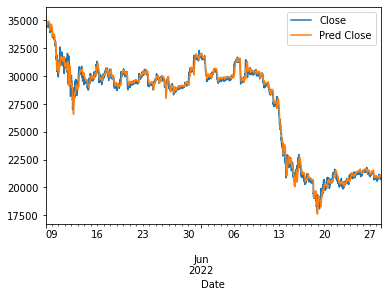

In [93]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

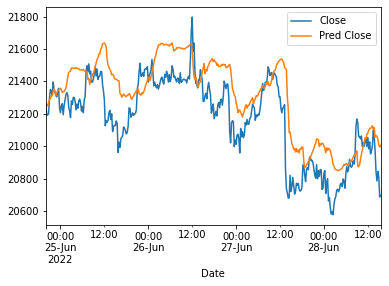

In [94]:
df_preds_true.dropna().iloc[-new_time_steps-100:].plot()

In [95]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-new_time_steps:], ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

ZeroDivisionError: ignored

Fee: 0.025
----------------------
Buy      32 ( 22 ok 10 ko )
Avg PCT gain: 1.0025080971794205
Avg PCT loss: 0.9975566558119965
Wins  PCT   0.6875
Avg PCT Gain.    1.0025080971794205
No-op    0
Wallet   595.9002499999995
Drawback -251.89375
Kelly Fraction    0.37654345429395875
Total earned 595.9002499999995


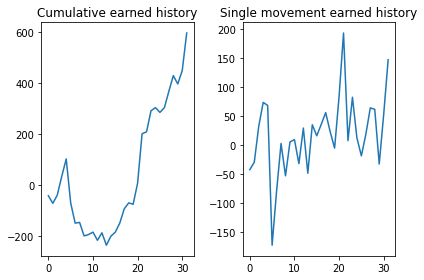

In [78]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-new_time_steps*2:], ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

All caught up..!
size of dataset: (167115, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (167115, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952
All caught up..!
size of dataset: (167115, 8)
Candles Normalized
Extracted last 2000 steps
Generated time-series
Normalized 'candles_norm' with shape : (2000, 9)
Feature data 'x_candles' with size : 1952
Feature data with time intervals 'x_time' with size : 1952


KeyboardInterrupt: ignored

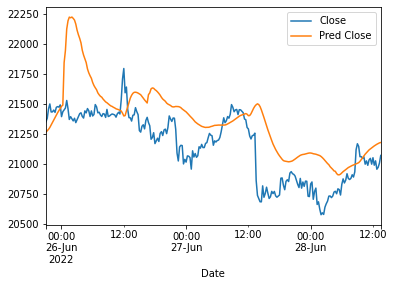

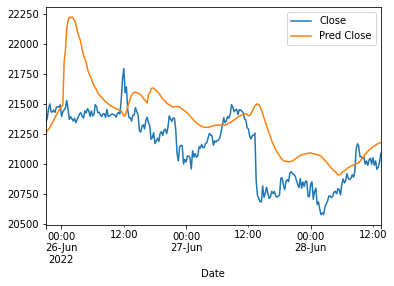

In [12]:
investment = 100.
conservative_kelly = kelly_frac*.5
portfolio = investment
order_status = "not_filled"

while True:

  ldata_df_new = crypto.load_cryptos(tickers,save = False)
  can_btc = fb.Candles(ldata_df_new,"Bitcoin")
  can_btc.buildfeatures()
  ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                  lownorm = 0.2, upnorm= 0.8)

  ts_btc.candles2ts()
  ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
  ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
  initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
  loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
  loaded_model.sats2model()
  loaded_model.load_model(model_name)
  loaded_model.sats2pred(predict_on_test = False)
  loaded_model.load_scaler(model_name + '/scaler.sav')
  preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
  new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
  df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
  df_preds_true.dropna().iloc[-new_time_steps:].plot()
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)

  prev_true_close = df_preds_true_shifted.iloc[-2,0]
  prev_pred_close = df_preds_true_shifted.iloc[-2,1]
  pred_close = df_preds_true_shifted.iloc[-1,1]

  fee = 0.025

  elapsed_minutes = (pd.Timestamp(datetime.now()) - df_preds_true.index[-1]).seconds/crypto.dt
  time_condition = delta.seconds/crypto.dt -1. < elapsed_minutes <  delta.seconds/crypto.dt + 1.

  if time_condition and order_status == "not_filled" :

    if prev_true_close*(1+fee) < pred_close:

        #get price
        price = crypto.binance_client.get_symbol_ticker(symbol=tickers[0])
        # Calculate how much to buy
        buy_quantity = round(portfolio*conservative_kelly / float(price['price']))
        buy_quantity = 0.001
        order = crypto.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
        
        order_status= "filled"
        






In [ ]:
  delta = df_preds_true.index[1]-df_preds_true.index[0]
  df_preds_true_shifted = df_preds_true.copy()
  df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)
  df_preds_true_shifted

In [ ]:
df_preds_true